# Introduccion

Bueno muchacho luego del pequeño tutorial de dataframes, toca meternos a territorio mas interesante :confounded:. Como recordaras la herramienta de muDAS esta compuesta de 4 modulos que van desde la consulta hasta el procesamiento de los datos de GEO. 

Por eso mismo antes de entrar el proyecto seria adecuado que te familiarices con cada uno de los procesos de la herramienta :smiley:. Como habras visto en el titulo del cuaderno esta vez sera la ocasion del modulo de query, es decir la consulta de los datos :racehorse:

# Entrez

In [1]:
import sys
print(sys.executable)
print(sys.path)

/home/majiso/.conda/envs/induccion/bin/python
['/home/majiso/.conda/envs/induccion/lib/python310.zip', '/home/majiso/.conda/envs/induccion/lib/python3.10', '/home/majiso/.conda/envs/induccion/lib/python3.10/lib-dynload', '', '/home/majiso/.conda/envs/induccion/lib/python3.10/site-packages']


In [2]:
# Primeramente necesitaras usar la libreria de entrez
from Bio import Entrez

In [3]:
# Entrez necesita que añadas un email para mandarte advertencias si te pasas de lanza con las consultas xd
Entrez.email = "aggonzal@lcg.unam.mx"

# Base de datos de GEO datasets
database = "gds"
# Entidad de GEO en este caso GEO experiments
geo_entry = "gse"
# Tu puedes construir un query como el que usarias en la pagina para buscar lo que te interesa nosotros buscamos experimentos de microarreglos para bacilus
query = f'(("{geo_entry}"[Entry Type]) AND "expression profiling by array"[DataSet Type]) AND "bacillus subtilis subsp subtilis str 168"[Organism]'
with Entrez.esearch(db=database, term=query) as handle:
    # Entrez nos ayuda a leer el output
    response = Entrez.read(handle)


In [4]:
# A nosotros nos interesa principalmente los IDs de los estudios 
response["IdList"]

['200206796', '200190460', '200151224', '200149595', '200156738', '200151596', '200145124', '200138828', '200138827', '200138829', '200141882', '200092397', '200092359', '200092348', '200132981', '200134218', '200107921', '200123974', '200126228', '200116655']

Nota que estos son los ids numericos de las entidades de experimentos las cuales siempre empizan con 2 y rellenan con 0s despues del 0 para llegar a nueves digitos con el id unico, es decir, si el id de geo es: GSE206796, su id como entidad es 2 y faltan dos numeros para llegar a los nueve digitos por lo que seria: 200206796

In [5]:
# Usando esummary puedes recuperar un 'summary' de los metadatos asociados a un determinado experimento 
with Entrez.esummary(db=database, id = 200206796) as handle: # O como 200206789, que es 'Homo Sapiens'
    record = Entrez.read(handle)

# Algunos de los metadatos que pueden ser utiles son:
print(f'El Geo accession: {record[0]["Accession"]}\nEl nombre taxonomico del organismo: {record[0]["taxon"]}\nEl tipo de tecnologia{record[0]["gdsType"]}...')

El Geo accession: GSE206796
El nombre taxonomico del organismo: Corynebacterium glutamicum; Bacillus subtilis subsp. subtilis str. 168; Gluconobacter oxydans 621H; Escherichia coli str. K-12 substr. MG1655; Pseudomonas putida KT2440
El tipo de tecnologiaExpression profiling by array...


In [ ]:
record[0]["FTPLink"]

'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE206nnn/GSE206796/'

In [7]:
id = record[0]["FTPLink"].split("/")
id[-2]
id

['ftp:',
 '',
 'ftp.ncbi.nlm.nih.gov',
 'geo',
 'series',
 'GSE206nnn',
 'GSE206796',
 '']

In [8]:
import os

_,_,host,*path=record[0]["FTPLink"].split("/")
print(host) # Servidor que ostenta los GSEs
print(path) # Guarda en una lista todo lo que no se guardó en las demás variables
print(os.path.join(*path))

ftp.ncbi.nlm.nih.gov
['geo', 'series', 'GSE206nnn', 'GSE206796', '']
geo/series/GSE206nnn/GSE206796/


In [21]:
import os # Otra vez, nada más para claridad en la celda
import ftplib # (File Transfer Protocol)
import gzip # Para comprimir archivos
from shutil import copyfileobj # Copar contenido de un archivo a otro ---> Objeto por objeto

# Pero si quieres acceder a los metadatos completos debes accerlo directamente desde el ftp
_,_,host,*path=record[0]["FTPLink"].split("/")
geo_id = path[-2]

path = os.path.join(*path) # path = geo/series/GSE206nnn/GSE206786/ ---> path de esa GSE

# Utilizamos la librería ftplib para descargar, mediante protocolo ftp, el archivo family

# Indicamos el sitio al que queremos acceder.
print(f"Conectandose a {host}...")
ftp = ftplib.FTP(host)
# Abrimos la conexión FTP
ftp.login() # Anónimo por default

# Descargamos el archivo
fileName = f"{geo_id}_family.soft.gz" # SOFT son los archivos de texto plano con los metadatos ---> Family indica que son de las GSMs de un GSE completo
print(f"Descargando {fileName}...")

if not os.path.exists("Results") or not os.path.isdir("Results"): # Sólo validación
     os.makedirs("Results")

with open(f"Results/{fileName}", "wb") as f: # Modo de escritura binario ---> Sólo bytes, no strings (b)
  ftp.retrbinary(f"RETR {os.path.join(path, 'soft',fileName)}", f.write) # Recupera el archivo del path {path}/soft/{filename}

print("Descarga completada!")

# Cerramos la conexión FTP
ftp.quit()

# Ahora tenemos el archivo descargado
print(f'Archivos en el directorio Results/ {os.listdir("Results/")}')

print("Descomprimiendo archivo...")
with gzip.open(soft := os.path.join("Results/", fileName)) as gz: # soft = Results/GSE206796_family.soft.gz
            with open(soft := soft.rstrip(".gz"), "wb") as out: # Quita el .gz
# := es walrus operator ---> Permite asignaciones dentro de expresiones
                copyfileobj(gz, out) # Desde un fsrc (source) hasta un fdst (destination)
print("Listo!")

# Ahora tenemos el archivo descomprimido
print(f'Archivos en el directorio Results/ {os.listdir("Results/")}')

# Ahora podemos ver el contenido del archivo family soft
with open(soft) as file:
    content = file.read()

# Aunque si queremos usarlo, antes hay que parsearlo
print(content)

Conectandose a ftp.ncbi.nlm.nih.gov...
Descargando GSE206796_family.soft.gz...
Descarga completada!
Archivos en el directorio Results/ ['GSE206796_family.soft.gz', 'GSE206796_family.soft']
Descomprimiendo archivo...
Listo!
Archivos en el directorio Results/ ['GSE206796_family.soft.gz', 'GSE206796_family.soft']
^DATABASE = GeoMiame
!Database_name = Gene Expression Omnibus (GEO)
!Database_institute = NCBI NLM NIH
!Database_web_link = http://www.ncbi.nlm.nih.gov/geo
!Database_email = geo@ncbi.nlm.nih.gov
^SERIES = GSE206796
!Series_title = Comparison of Corynebacterium glutamicum wild type with C. glutamicum ChrS-Ala245fs
!Series_geo_accession = GSE206796
!Series_status = Public on Jul 22 2022
!Series_submission_date = Jun 23 2022
!Series_last_update_date = Oct 04 2022
!Series_pubmed_id = 36160252
!Series_summary = In an evolutionary experiment on high hemin concentrations, a frameshift mutation in the ChrS gene was figured out to be striking in survival at high hemin concentrations (Ala2

# GEOparse

In [22]:
record[0]["Accession"]

'GSE206796'

In [ ]:
# Pero no te preocupes, todo ese doloroso proceso ya lo puede hacer la libreria de GEOparse
import GEOparse as geo
import re
# Desde solo el parseo 
gse_parse = geo.get_GEO(filepath=soft) # Objeto GSE analizable
# Hasta la descarga (nota que tienes que usar el geo accession, no el numerico)
gse_download = geo.get_GEO(geo=re.sub("^20*","GSE",record[0]["Accession"]),destdir="Results") # 200206796 ---> GSE206796

19-Jun-2025 06:23:54 INFO GEOparse - Parsing Results/GSE206796_family.soft: 
19-Jun-2025 06:23:54 DEBUG GEOparse - DATABASE: GeoMiame
19-Jun-2025 06:23:54 DEBUG GEOparse - SERIES: GSE206796
19-Jun-2025 06:23:54 DEBUG GEOparse - PLATFORM: GPL32387


19-Jun-2025 06:23:54 DEBUG GEOparse - SAMPLE: GSM6262951
19-Jun-2025 06:23:54 DEBUG GEOparse - SAMPLE: GSM6262952
19-Jun-2025 06:23:54 DEBUG GEOparse - SAMPLE: GSM6262953
19-Jun-2025 06:23:54 DEBUG utils - Directory Results already exists. Skipping.
19-Jun-2025 06:23:54 INFO GEOparse - File already exist: using local version.
19-Jun-2025 06:23:54 INFO GEOparse - Parsing Results/GSE206796_family.soft.gz: 
19-Jun-2025 06:23:54 DEBUG GEOparse - DATABASE: GeoMiame
19-Jun-2025 06:23:54 DEBUG GEOparse - SERIES: GSE206796
19-Jun-2025 06:23:54 DEBUG GEOparse - PLATFORM: GPL32387
19-Jun-2025 06:23:54 DEBUG GEOparse - SAMPLE: GSM6262951
19-Jun-2025 06:23:55 DEBUG GEOparse - SAMPLE: GSM6262952
19-Jun-2025 06:23:55 DEBUG GEOparse - SAMPLE: GSM6262953


In [12]:
# Ahora si tenemos accesso a sus metadatos 
# A nivel de GSE
gse_download.metadata

{'title': ['Comparison of Corynebacterium glutamicum wild type with C. glutamicum ChrS-Ala245fs'],
 'geo_accession': ['GSE206796'],
 'status': ['Public on Jul 22 2022'],
 'submission_date': ['Jun 23 2022'],
 'last_update_date': ['Oct 04 2022'],
 'pubmed_id': ['36160252'],
 'summary': ['In an evolutionary experiment on high hemin concentrations, a frameshift mutation in the ChrS gene was figured out to be striking in survival at high hemin concentrations (Ala245fs). Apart from high upregulation of heme exporter hrtB, microarrays should reveal further different controlled genes compared to the WT.'],
 'overall_design': ['The aim was to identify genes differentially expressed genes between the C. glutamicum ChrS-Ala245fs mutant and WT reference strain. Triplicate experiments inlcuding a color swap were carried out.'],
 'type': ['Expression profiling by array'],
 'contributor': ['Aileen,,Krüger', 'Julia,,Frunzke'],
 'sample_id': ['GSM6262951', 'GSM6262952', 'GSM6262953'],
 'contact_name': 

In [13]:
# A nivel de GSM 
for gsm,data in gse_download.gsms.items():
    print(gsm,data.metadata)

GSM6262951 {'title': ['ChrS-Ala245fs_vs_WT_1'], 'geo_accession': ['GSM6262951'], 'status': ['Public on Jul 22 2022'], 'submission_date': ['Jun 23 2022'], 'last_update_date': ['Jul 22 2022'], 'type': ['RNA'], 'channel_count': ['2'], 'source_name_ch1': ['ChrS-Ala245fs_4uM_hemin'], 'organism_ch1': ['Corynebacterium glutamicum'], 'taxid_ch1': ['1718'], 'characteristics_ch1': ['genotype: ChrS-Ala245fs'], 'treatment_protocol_ch1': ['see growth protocol'], 'growth_protocol_ch1': ['pre-culture 1: in reaction tubes, 5 ml BHI, triplicates (3x WT, 3x ChrS-Ala245fs mutant), inoculated from a fresh agar plate, 30 C, 170 rpm, ~ 8 h; pre-culture 2: in 100 ml flasks, 2 ml of pre-culture 1 was transferred to 20 ml CGXII + 2% glucose + PCA + trace elements without any iron, 30 C, 120 rpm, over night;  main culture: 500 ml flasks, cells were pelleted so that they were inoculated at an OD of 1 in 50 ml CGXII + 2% glucose + PCA + trace elements without iron + 4 µM hemin;'], 'molecule_ch1': ['total RNA'], '

In [14]:
# A nivel de GPL
for gpl,data in gse_download.gpls.items():
    print(gpl,data.metadata)

GPL32387 {'title': ['FZ_IBG1_4plex_086337_all'], 'geo_accession': ['GPL32387'], 'status': ['Public on Jul 22 2022'], 'submission_date': ['Jun 23 2022'], 'last_update_date': ['Jul 24 2022'], 'technology': ['spotted oligonucleotide'], 'distribution': ['custom-commercial'], 'organism': ['Corynebacterium glutamicum', 'Pseudomonas putida KT2440', 'Bacillus subtilis subsp. subtilis str. 168', 'Gluconobacter oxydans 621H', 'Escherichia coli str. K-12 substr. MG1655'], 'taxid': ['1718', '160488', '224308', '290633', '511145'], 'manufacturer': ['Agilent Technologies (Waldbronn, Germany)'], 'manufacture_protocol': ['see Agilent Technologies'], 'description': ['synthesized 60mer oligonucleotides'], 'contact_name': ['Tino,,Polen'], 'contact_email': ['t.polen@fz-juelich.de'], 'contact_department': ['IBG-1: Biotechnology'], 'contact_institute': ['Forschungszentrum Jülich GmbH'], 'contact_address': ['Wilhelm-Johnen-Str 1'], 'contact_city': ['Juelich'], 'contact_state': ['NRW'], 'contact_zip/postal_co

# Actividad :fire: :racehorse:

Ahora que tienes acceso a los metadatos puedes tener un mejor entendimiento de tus datos por lo que puedes identificar aquellos que son potencialmente utiles con base en lo que te interesa como el organismo, o bien al accesso de los datos suplementarios. 

Ahora con ese antecedente te voy a pedir que realices lo siguiente:
- Conseguir el id de al menos 100 experimentos de microarreglos que unicamente sean del organismo: Escherichia coli k-12
- Descargar y parsear los archivos SOFT para tener acceso as sus metadatos
- Agregar una serie de banderas que te permitan saber aquellos GSMs que puede valer la pena descargar sus archivo supplementario mas adelantes. Las banderas minimas que debes usar son:
    - TECHNOLOGY: Solo selecciona aquellos samples asociados a plataformas que sean de las siguiente tecnologias: `['in situ oligonucleotide', 'spotted oligonucleotide', 'spotted DNA/cDNA', 'mixed spotted oligonucleotide/cDNA']`
    - VALID_CH1/2: Determina que gsms tienen uno o dos canales en caso, y entonces evaluar si el id taxonomico asociado al canal coincide con el del la serie, es decir que es igual
    - NUM_SUPP: Determina si el sample tiene uno o mas archivos suplementarios
- Despues de añadir las banderas, crea un dataframe que compile todos los metadatos obtenidos y las banderas que se añadiero. Donde las columnas sea los metadatos y las filas los identificadores de los gsm
- Genera la cantidad y tipo de plots que consideres apropiados para reportar como estan tus datos. 
- Guarda un archivo csv o tsv de tu dataframe

## Respuesta
> Approach 1

### GSEs de microarreglos de *E. coli*

In [1]:
import os
import ftplib # (File Transfer Protocol)
import gzip # Para comprimir archivos
import GEOparse as geo
import pandas as pd
from shutil import copyfileobj # Copia contenido de un archivo a otro ---> Objeto por objeto
from Bio import Entrez


In [ ]:
# Email
Entrez.email = "majiso@lcg.unam.mx"

# Parámetros de búsqueda
database = "gds" # GEO datasets
geo_entry = "gse" # GEO series
ds_type = "expression profiling by array"
ecoli = "escherichia coli"
organism = [f"{ecoli} str. k12", f"{ecoli} str k12", f"{ecoli} k12"] # No se encontraron resultados con 'str' o 'str.'

response = None

for name in organism:
    # Query de microrrays en E. coli
    query = f'(("{geo_entry}"[Entry Type]) AND "{ds_type}"[DataSet Type]) AND "{name}"[Organism]'
    with Entrez.esearch(db=database, term=query, retmax=500) as handle: # parámetro de retmax para que no retornara sólo los primeros 20
        response = Entrez.read(handle)
    if int(n_gse := response["Count"]) > 0: # Si hubieron respuestas
        print(f"Se encontraron {n_gse} resultados con '{name}'")
        break
    else:
        print(f"No se encontraron resultados con '{name}'")



No se encontraron resultados con 'escherichia coli str. k12'
No se encontraron resultados con 'escherichia coli str k12'
Se encontraron 255 resultados con 'escherichia coli k12'


In [ ]:
gse_ids = response["IdList"]
print(len(gse_ids)) # > 100
print(gse_ids) # Necesitamos el id de GEO

255
['200289056', '200260863', '200211579', '200206796', '200206196', '200181402', '200178954', '200137882', '200144316', '200144315', '200118058', '200100022', '200126228', '200102347', '200116652', '200116577', '200116576', '200110168', '200120726', '200116304', '200110730', '200112421', '200093896', '200045979', '200107550', '200106630', '200106628', '200089746', '200094342', '200102322', '200098505', '200080827', '200069517', '200099661', '200071784', '200096955', '200067735', '200086341', '200073640', '200087627', '200073707', '200085807', '200068287', '200079305', '200080002', '200079509', '200063052', '200072525', '200037780', '200070688', '200070325', '200069265', '200056833', '200038186', '200062898', '200066995', '200058509', '200059441', '200058912', '200062094', '200046455', '200047427', '200032131', '200055662', '200055972', '200013181', '200013179', '200013178', '200058176', '200055879', '200058977', '200058976', '200058927', '200058902', '200058806', '200054512', '200046

### Descarga y parseo de archivos *SOFT* de los GSEs

In [2]:
def listar_soft() -> list:
    
    if not os.path.exists("Results") or not os.path.isdir("Results"): # Sólo validación
        os.makedirs("Results")

    return [f for f in os.listdir("Results") if f.endswith("_family.soft")]

In [ ]:
gses_previos = listar_soft()

In [ ]:
summaries = {}
contador = 0
keys_err = ["no descargados", "no descomprimidos"]
errores = {key: [] for key in keys_err} # Listas vacías, independientes
n_archivos = len(gse_ids)

for i, gse_id in enumerate(gse_ids):
    # Guardado de hosts y paths
    with Entrez.esummary(db=database, id=gse_id) as handle: # 200289056, 200260863, 200211579, etc...
        summary = Entrez.read(handle)[0] # Desde aquí nos quedamos sólo con esa fila

    _,_,host,*path_it = summary["FTPLink"].split("/")
    geo_gse_id = path_it[-2] # ID de GEO, no numérico ---> GSE289056, GSE260863, GSE211579, etc...
    path = os.path.join(*path_it)

    fileName = f"{geo_gse_id}_family.soft.gz" # Family indica que son de las GSMs de un GSE completo

    if fileName in gses_previos:
        ftp.quit()
        continue

    # Apertura de conexión FTP
    ftp = ftplib.FTP(host) # Aunque es el mismo host, después de n consultas, la conexión se cierra
    ftp.login()

    summaries[geo_gse_id] = summary # Dict de dicts que nos permite hacer búsquedas por gse_id de GEO y por campo
    summaries[geo_gse_id]["Path"] = path

    # Descarga de SOFTs
    try: 
        with open(f"Results/{fileName}", "wb") as f: # Modo de escritura binario ---> Sólo bytes, no strings (b)
            ftp.retrbinary(f"RETR {os.path.join(path, 'soft',fileName)}", f.write) # Recupera el archivo del path {path}/soft/{filename}

    except Exception as e:
        errores["no descargados"].append((fileName, str(e)))
        ftp.quit()
        continue

    try:
        with gzip.open(soft := os.path.join("Results/", fileName)) as gz: # soft = Results/{geo_gse_id}_family.soft.gz
            with open(soft.rstrip(".gz"), "wb") as out: # Quita el .gz
                copyfileobj(gz, out) # Desde un fsrc (source) hasta un fdst (destination)
    except Exception as e:
        errores["no descomprimidos"].append((fileName, str(e)))
        ftp.quit()
        continue

    # Cierre de conexión FTP
    ftp.quit()

    contador += 1
    print(f"Progreso:\t{round((((i + 1) / n_archivos) * 100), 5)}%")

print(f"{contador}/{n_archivos} archivos nuevos descargados (sin contar .gz)")
print(f'Archivos en el directorio Results/ {os.listdir("Results/")}')

Progreso:	0.39216%
Progreso:	0.78431%
Progreso:	1.17647%
Progreso:	1.56863%
Progreso:	1.96078%
Progreso:	2.35294%
Progreso:	2.7451%
Progreso:	3.13725%
Progreso:	3.52941%
Progreso:	3.92157%
Progreso:	4.31373%
Progreso:	4.70588%
Progreso:	5.09804%
Progreso:	5.4902%
Progreso:	5.88235%
Progreso:	6.27451%
Progreso:	6.66667%
Progreso:	7.05882%
Progreso:	7.45098%
Progreso:	7.84314%
Progreso:	8.23529%
Progreso:	8.62745%
Progreso:	9.01961%
Progreso:	9.41176%
Progreso:	9.80392%
Progreso:	10.19608%
Progreso:	10.58824%
Progreso:	10.98039%
Progreso:	11.37255%
Progreso:	11.76471%
Progreso:	12.15686%
Progreso:	12.54902%
Progreso:	12.94118%
Progreso:	13.33333%
Progreso:	13.72549%
Progreso:	14.11765%
Progreso:	14.5098%
Progreso:	14.90196%
Progreso:	15.29412%
Progreso:	15.68627%
Progreso:	16.07843%
Progreso:	16.47059%
Progreso:	16.86275%
Progreso:	17.2549%
Progreso:	17.64706%
Progreso:	18.03922%
Progreso:	18.43137%
Progreso:	18.82353%
Progreso:	19.21569%
Progreso:	19.60784%
Progreso:	20.0%
Progreso:	20.

In [43]:
print(contador)
print(errores["no descargados"])
print(errores["no descomprimidos"])
print(errores.items())

255
[]
[]
dict_items([('no descargados', []), ('no descomprimidos', [])])


In [ ]:
# Escritura de archivo
with open(os.path.join("Results/", "errores.txt"), "w") as f:
    f.write("Archivo/tError")
    for tipo_error, lista in errores.items():
        for archivo, error in lista:
            f.write(f"{archivo}\t{error}")

### Parseo
> Al no haberse descargado con *get_GEO* de forma automática, ahora se parseará localmente

> Para ello volvemos a ejecutar la funcioncita de *listar_soft*

In [4]:
#summaries['GSE289056']["Accession"]
soft_files = listar_soft() # Todos los *_family.soft

In [5]:
gse_parse = {}
gse_ids = []

for archivo in soft_files:
    soft = os.path.join("Results/", archivo)
    gse_id = archivo.split("_")[0] # Guarda el ID de GEO: GSE206196_family.soft ---> GSE206196
    gse_ids.append(gse_id)

    gse_parse[gse_id] = geo.get_GEO(filepath=soft) # ID de key, objeto parseable COMPLETO de value

24-Jun-2025 12:18:18 INFO GEOparse - Parsing Results/GSE206796_family.soft: 
24-Jun-2025 12:18:18 DEBUG GEOparse - DATABASE: GeoMiame
24-Jun-2025 12:18:18 DEBUG GEOparse - SERIES: GSE206796
24-Jun-2025 12:18:18 DEBUG GEOparse - PLATFORM: GPL32387
24-Jun-2025 12:18:18 DEBUG GEOparse - SAMPLE: GSM6262951
24-Jun-2025 12:18:18 DEBUG GEOparse - SAMPLE: GSM6262952
24-Jun-2025 12:18:18 DEBUG GEOparse - SAMPLE: GSM6262953
24-Jun-2025 12:18:18 INFO GEOparse - Parsing Results/GSE289056_family.soft: 
24-Jun-2025 12:18:18 DEBUG GEOparse - DATABASE: GeoMiame
24-Jun-2025 12:18:18 DEBUG GEOparse - SERIES: GSE289056
24-Jun-2025 12:18:18 DEBUG GEOparse - PLATFORM: GPL35385
24-Jun-2025 12:18:18 DEBUG GEOparse - SAMPLE: GSM8782701
24-Jun-2025 12:18:18 DEBUG GEOparse - SAMPLE: GSM8782702
24-Jun-2025 12:18:18 DEBUG GEOparse - SAMPLE: GSM8782703
24-Jun-2025 12:18:18 DEBUG GEOparse - SAMPLE: GSM8782704
24-Jun-2025 12:18:18 INFO GEOparse - Parsing Results/GSE260863_family.soft: 
24-Jun-2025 12:18:18 DEBUG GEO

In [6]:
import pandas as pd

gse_dict = {} # GSE de key, taxid ID de Values
gsm_dict = {} # Creación de dict pero de GSMs
gpl_dict = {} # GPL id de key, technology de value
gsm_gse = {} # GSM id de key, GSE id de value

for gse_id in gse_ids: # Quitar redundancia aquí ---> No la quité porque pues al final sí los usé para más cosas...
    parseado = gse_parse[gse_id]

    # A nivel de GSE
    gse_dict[gse_id] = parseado.metadata["sample_taxid"]

    # A nivel de GSM 
    for gsm_id, data in parseado.gsms.items():
        metadatos = data.metadata.copy()
        gsm_dict[gsm_id] = metadatos # Asegurarse de no modificar el original

        gsm_gse[gsm_id] = gse_id


    # A nivel de GPL
    for gpl_id, data in parseado.gpls.items():
        metadatos = data.metadata.copy()
        gpl_dict[gpl_id] = metadatos

df = pd.DataFrame.from_dict(gsm_dict, orient='index')
df_gpl = pd.DataFrame.from_dict(gpl_dict, orient='index')

### Uso de banderas para agregar columnas

**De cada GSE:**
- gse.metadata["geo_accession"]
- gse.metadata["title"]	
- gse.metadata["sample_taxid"]
- gse.metadata["platform_id"] ---> IDs de plataformas usadas

**De cada GSM:**
- gsm.metadata["platform_id"]
- gsm.metadata["channel_count"]
- gsm.metadata["taxid_ch1"]
- gsm.metadata["taxid_ch2"]
- gsm.metadata["platform_id"]
- gsm.metadata["supplementary_file"]

**De cada GPL:**
- gpl.metadata["geo_accession"]
- gpl.metadata["title"]
- gpl.metadata["technology"]

In [ ]:
df.to_csv("Results/dataframe.tsv", sep="\t")

In [14]:
df_gpl.to_csv("Results/gpl_metadata.tsv", sep="\t")

In [86]:
import ast
import pandas as pd # Por si retomo desde aquí

df = pd.read_csv("Results/dataframe.tsv",sep="\t",index_col=0)

def hacer_eval(celda): # porque no se puede usar Try dentro de lambda
    try:
        return ast.literal_eval(celda)
        df = df.apply(lambda col: col.map(hacer_eval)) 
    except (ValueError, SyntaxError):
        return celda

In [87]:
df = df.apply(lambda col: col.map(hacer_eval)) 

In [39]:
df

title geo_accession  \
GSM6262951                            [ChrS-Ala245fs_vs_WT_1]  [GSM6262951]   
GSM6262952                            [ChrS-Ala245fs_vs_WT_2]  [GSM6262952]   
GSM6262953                            [ChrS-Ala245fs_vs_WT_3]  [GSM6262953]   
GSM8782701  [Response of the parental JU15 strain during t...  [GSM8782701]   
GSM8782702  [Response of the parental JU15 strain during t...  [GSM8782702]   
...                                                       ...           ...   
GSM18285                                [anaerobic_soxS_rep3]    [GSM18285]   
GSM18286                                [anaerobic_wild_rep1]    [GSM18286]   
GSM18287                                [anaerobic_wild_rep2]    [GSM18287]   
GSM18288                                [anaerobic_wild_rep3]    [GSM18288]   
GSM18289                                [anaerobic_wild_rep4]    [GSM18289]   

                             status submission_date last_update_date   type  \
GSM6262951  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM6262952  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM6262953  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM8782701  [Public on May 29 2025]   [Feb 07 2025]    [May 29 2025]  [RNA]   
GSM8782702  [Public on May 29 2025]   [Feb 07 2025]    [May 29 2025]  [RNA]   
...                             ...             ...              ...    ...   
GSM18285    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18286    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18287    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18288    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18289    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   

           channel_count                                    source_name_ch1  \
GSM6262951           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM6262952           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM6262953           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM8782701           [2]  [Control samples of the parental strain JU15 a...   
GSM8782702           [2]  [Control samples of the parental strain JU15 a...   
...                  ...                                                ...   
GSM18285             [1]  [anaerobic growth of soxS knock-out strain on ...   
GSM18286             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18287             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18288             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18289             [1]  [anaerobic growth of wild-type strain on M9 me...   

                            organism_ch1 taxid_ch1  ... instrument_model  \
GSM6262951  [Corynebacterium glutamicum]    [1718]  ...              NaN   
GSM6262952  [Corynebacterium glutamicum]    [1718]  ...              NaN   
GSM6262953  [Corynebacterium glutamicum]    [1718]  ...              NaN   
GSM8782701            [Escherichia coli]     [562]  ...              NaN   
GSM8782702            [Escherichia coli]     [562]  ...              NaN   
...                                  ...       ...  ...              ...   
GSM18285              [Escherichia coli]     [562]  ...              NaN   
GSM18286              [Escherichia coli]     [562]  ...              NaN   
GSM18287              [Escherichia coli]     [562]  ...              NaN   
GSM18288              [Escherichia coli]     [562]  ...              NaN   
GSM18289              [Escherichia coli]     [562]  ...              NaN   

           library_selection library_source library_strategy  \
GSM6262951               NaN            NaN              NaN   
GSM6262952               NaN            NaN              NaN   
GSM6262953               NaN            NaN              NaN   
GSM8782701               NaN            

#### Technology

In [7]:
tecnologias = ['in situ oligonucleotide', 'spotted oligonucleotide', 'spotted DNA/cDNA', 'mixed spotted oligonucleotide/cDNA']

In [10]:
gsm_gpl = df["platform_id"].to_dict() # Por sí solo devuelve listas, aunque sean de un elemento
gsm_gpl.items() # Diccionario de id de GSM y su id de GPL

dict_items([('GSM6262951', ['GPL32387']), ('GSM6262952', ['GPL32387']), ('GSM6262953', ['GPL32387']), ('GSM8782701', ['GPL35385']), ('GSM8782702', ['GPL35385']), ('GSM8782703', ['GPL35385']), ('GSM8782704', ['GPL35385']), ('GSM8125782', ['GPL18948']), ('GSM8125783', ['GPL18948']), ('GSM8125784', ['GPL18948']), ('GSM8125785', ['GPL18948']), ('GSM8125786', ['GPL18948']), ('GSM8125787', ['GPL18948']), ('GSM8125788', ['GPL18948']), ('GSM8125789', ['GPL18948']), ('GSM8125790', ['GPL18948']), ('GSM8125791', ['GPL18948']), ('GSM8125792', ['GPL18948']), ('GSM8125793', ['GPL18948']), ('GSM8125794', ['GPL18948']), ('GSM8125795', ['GPL18948']), ('GSM8125796', ['GPL18948']), ('GSM8125797', ['GPL18948']), ('GSM6481068', ['GPL10416']), ('GSM6481069', ['GPL10416']), ('GSM6481070', ['GPL10416']), ('GSM6481071', ['GPL10416']), ('GSM6481072', ['GPL10416']), ('GSM6481073', ['GPL10416']), ('GSM6481074', ['GPL10416']), ('GSM6481075', ['GPL10416']), ('GSM6481076', ['GPL10416']), ('GSM6481077', ['GPL10416'])

In [9]:
gpl_tec = df_gpl["technology"].to_dict()
gpl_tec.items()

dict_items([('GPL32387', ['spotted oligonucleotide']), ('GPL35385', ['spotted oligonucleotide']), ('GPL18948', ['in situ oligonucleotide']), ('GPL10416', ['in situ oligonucleotide']), ('GPL13359', ['in situ oligonucleotide']), ('GPL27511', ['in situ oligonucleotide']), ('GPL25406', ['in situ oligonucleotide']), ('GPL14649', ['in situ oligonucleotide']), ('GPL23500', ['spotted oligonucleotide']), ('GPL23003', ['spotted oligonucleotide']), ('GPL13360', ['in situ oligonucleotide']), ('GPL22792', ['in situ oligonucleotide']), ('GPL3154', ['in situ oligonucleotide']), ('GPL6480', ['in situ oligonucleotide']), ('GPL24327', ['in situ oligonucleotide']), ('GPL24239', ['in situ oligonucleotide']), ('GPL16048', ['in situ oligonucleotide']), ('GPL20978', ['in situ oligonucleotide']), ('GPL11366', ['spotted oligonucleotide']), ('GPL19391', ['in situ oligonucleotide']), ('GPL20675', ['in situ oligonucleotide']), ('GPL15818', ['spotted oligonucleotide']), ('GPL7535', ['spotted oligonucleotide']), ('

In [11]:
# Depurar las listas de un elemento que había en los diccionarios creados
def depurar(dict) -> dict:
    for key, value in dict.items():
        try:
            if isinstance(value, list): 
                if len(value) == 1:
                    dict[key] = value[0]
                    continue
            dict[key] = value
        except Exception as e:
            print(f'Error: elemento {value} no ha podido ser filtrado.')
        continue

    return dict # ya limpio

In [12]:
gsm_gpl_limpio = depurar(gsm_gpl)
gsm_gpl_limpio.values()

dict_values(['GPL32387', 'GPL32387', 'GPL32387', 'GPL35385', 'GPL35385', 'GPL35385', 'GPL35385', 'GPL18948', 'GPL18948', 'GPL18948', 'GPL18948', 'GPL18948', 'GPL18948', 'GPL18948', 'GPL18948', 'GPL18948', 'GPL18948', 'GPL18948', 'GPL18948', 'GPL18948', 'GPL18948', 'GPL18948', 'GPL18948', 'GPL10416', 'GPL10416', 'GPL10416', 'GPL10416', 'GPL10416', 'GPL10416', 'GPL10416', 'GPL10416', 'GPL10416', 'GPL10416', 'GPL10416', 'GPL10416', 'GPL10416', 'GPL10416', 'GPL10416', 'GPL10416', 'GPL10416', 'GPL10416', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL13359', 'GPL27511', 'GPL27511', 'GPL27511', 'GPL27511', 'GPL27511', 'GPL27511', 'GPL27511', 'GPL27511', 'GPL25406', 'GP

In [13]:
tiene_listas = any(isinstance(v, list) for v in gsm_gpl_limpio.values())
print(tiene_listas) # True si al menos un value sí lista

False


In [ ]:
# Bandera de tecnología
for gsm_id, gpl_id in gsm_gpl_limpio.items():
    df.loc[gsm_id, "technology"] = gpl_tec[gpl_id][0] in tecnologias # True o False ---> Elemento 0 porque recordemos que son listas

In [125]:
df # Aquí ya incorpora la banderade technology

title geo_accession  \
GSM6262951                            [ChrS-Ala245fs_vs_WT_1]  [GSM6262951]   
GSM6262952                            [ChrS-Ala245fs_vs_WT_2]  [GSM6262952]   
GSM6262953                            [ChrS-Ala245fs_vs_WT_3]  [GSM6262953]   
GSM8782701  [Response of the parental JU15 strain during t...  [GSM8782701]   
GSM8782702  [Response of the parental JU15 strain during t...  [GSM8782702]   
...                                                       ...           ...   
GSM18285                                [anaerobic_soxS_rep3]    [GSM18285]   
GSM18286                                [anaerobic_wild_rep1]    [GSM18286]   
GSM18287                                [anaerobic_wild_rep2]    [GSM18287]   
GSM18288                                [anaerobic_wild_rep3]    [GSM18288]   
GSM18289                                [anaerobic_wild_rep4]    [GSM18289]   

                             status submission_date last_update_date   type  \
GSM6262951  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM6262952  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM6262953  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM8782701  [Public on May 29 2025]   [Feb 07 2025]    [May 29 2025]  [RNA]   
GSM8782702  [Public on May 29 2025]   [Feb 07 2025]    [May 29 2025]  [RNA]   
...                             ...             ...              ...    ...   
GSM18285    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18286    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18287    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18288    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18289    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   

           channel_count                                    source_name_ch1  \
GSM6262951           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM6262952           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM6262953           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM8782701           [2]  [Control samples of the parental strain JU15 a...   
GSM8782702           [2]  [Control samples of the parental strain JU15 a...   
...                  ...                                                ...   
GSM18285             [1]  [anaerobic growth of soxS knock-out strain on ...   
GSM18286             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18287             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18288             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18289             [1]  [anaerobic growth of wild-type strain on M9 me...   

                            organism_ch1 taxid_ch1  ... library_selection  \
GSM6262951  [Corynebacterium glutamicum]    [1718]  ...               NaN   
GSM6262952  [Corynebacterium glutamicum]    [1718]  ...               NaN   
GSM6262953  [Corynebacterium glutamicum]    [1718]  ...               NaN   
GSM8782701            [Escherichia coli]     [562]  ...               NaN   
GSM8782702            [Escherichia coli]     [562]  ...               NaN   
...                                  ...       ...  ...               ...   
GSM18285              [Escherichia coli]     [562]  ...               NaN   
GSM18286              [Escherichia coli]     [562]  ...               NaN   
GSM18287              [Escherichia coli]     [562]  ...               NaN   
GSM18288              [Escherichia coli]     [562]  ...               NaN   
GSM18289              [Escherichia coli]     [562]  ...               NaN   

           library_source library_strategy supplementary_file_1  \
GSM6262951            NaN              NaN                  NaN   
GSM6262952            NaN              NaN                  NaN   
GSM6262953            NaN              NaN                  NaN   
GSM8782701      

#### Canales

In [55]:
df.columns

Index(['title', 'geo_accession', 'status', 'submission_date',
       'last_update_date', 'type', 'channel_count', 'source_name_ch1',
       'organism_ch1', 'taxid_ch1', 'characteristics_ch1',
       'treatment_protocol_ch1', 'growth_protocol_ch1', 'molecule_ch1',
       'extract_protocol_ch1', 'label_ch1', 'label_protocol_ch1',
       'source_name_ch2', 'organism_ch2', 'taxid_ch2', 'characteristics_ch2',
       'treatment_protocol_ch2', 'growth_protocol_ch2', 'molecule_ch2',
       'extract_protocol_ch2', 'label_ch2', 'label_protocol_ch2',
       'hyb_protocol', 'scan_protocol', 'data_processing', 'platform_id',
       'contact_name', 'contact_email', 'contact_department',
       'contact_institute', 'contact_address', 'contact_city', 'contact_state',
       'contact_zip/postal_code', 'contact_country', 'supplementary_file',
       'series_id', 'data_row_count', 'description', 'contact_phone',
       'contact_laboratory', 'relation', 'instrument_model',
       'library_selection', 'lib

In [56]:
df.loc[:,["taxid_ch1", "taxid_ch1", "series_id"]]

taxid_ch1 taxid_ch1           series_id
GSM6262951    [1718]    [1718]         [GSE206796]
GSM6262952    [1718]    [1718]         [GSE206796]
GSM6262953    [1718]    [1718]         [GSE206796]
GSM8782701     [562]     [562]         [GSE289056]
GSM8782702     [562]     [562]         [GSE289056]
...              ...       ...                 ...
GSM18285       [562]     [562]  [GSE1107, GSE1121]
GSM18286       [562]     [562]  [GSE1107, GSE1121]
GSM18287       [562]     [562]  [GSE1107, GSE1121]
GSM18288       [562]     [562]  [GSE1107, GSE1121]
GSM18289       [562]     [562]  [GSE1107, GSE1121]

[3718 rows x 3 columns]

In [57]:
gse_dict

{'GSE206796': ['1718'],
 'GSE289056': ['562'],
 'GSE260863': ['511145'],
 'GSE211579': ['562'],
 'GSE206196': ['562'],
 'GSE181402': ['679895'],
 'GSE178954': ['679895'],
 'GSE137882': ['511145'],
 'GSE144316': ['511145'],
 'GSE144315': ['511145'],
 'GSE118058': ['511145'],
 'GSE100022': ['469008'],
 'GSE126228': ['679895'],
 'GSE102347': ['562'],
 'GSE116652': ['511145'],
 'GSE116577': ['511145'],
 'GSE116576': ['511145'],
 'GSE110168': ['511145'],
 'GSE120726': ['511145'],
 'GSE116304': ['562'],
 'GSE110730': ['511145'],
 'GSE112421': ['1401689'],
 'GSE93896': ['511145'],
 'GSE45979': ['562', '9606'],
 'GSE107550': ['1264', '45796', '47894', '59374', '83333', '506599', '657309'],
 'GSE106630': ['511145', '588858'],
 'GSE106628': ['511145'],
 'GSE89746': ['1110693'],
 'GSE94342': ['562'],
 'GSE102322': ['83333'],
 'GSE98505': ['1403831'],
 'GSE80827': ['562'],
 'GSE69517': ['83333'],
 'GSE99661': ['562'],
 'GSE71784': ['511145'],
 'GSE96955': ['83333'],
 'GSE67735': ['511145'],
 'GSE8

In [46]:
gsm_gse

{'GSM6262951': 'GSE206796',
 'GSM6262952': 'GSE206796',
 'GSM6262953': 'GSE206796',
 'GSM8782701': 'GSE289056',
 'GSM8782702': 'GSE289056',
 'GSM8782703': 'GSE289056',
 'GSM8782704': 'GSE289056',
 'GSM8125782': 'GSE260863',
 'GSM8125783': 'GSE260863',
 'GSM8125784': 'GSE260863',
 'GSM8125785': 'GSE260863',
 'GSM8125786': 'GSE260863',
 'GSM8125787': 'GSE260863',
 'GSM8125788': 'GSE260863',
 'GSM8125789': 'GSE260863',
 'GSM8125790': 'GSE260863',
 'GSM8125791': 'GSE260863',
 'GSM8125792': 'GSE260863',
 'GSM8125793': 'GSE260863',
 'GSM8125794': 'GSE260863',
 'GSM8125795': 'GSE260863',
 'GSM8125796': 'GSE260863',
 'GSM8125797': 'GSE260863',
 'GSM6481068': 'GSE211579',
 'GSM6481069': 'GSE211579',
 'GSM6481070': 'GSE211579',
 'GSM6481071': 'GSE211579',
 'GSM6481072': 'GSE211579',
 'GSM6481073': 'GSE211579',
 'GSM6481074': 'GSE211579',
 'GSM6481075': 'GSE211579',
 'GSM6481076': 'GSE211579',
 'GSM6481077': 'GSE211579',
 'GSM6481078': 'GSE211579',
 'GSM6481079': 'GSE211579',
 'GSM6481080': 'GSE2

In [ ]:
"GSE106629" in gsm_gse.values() # Ya no se incluye ningún GSE id externo

False

In [93]:
for gsm_id, gse_id in gsm_gse.items():

    # Lista con los IDs de táxidos válidos
    taxid_ids = df.loc[gsm_id,["taxid_ch1", "taxid_ch1"]].to_list()

    taxid_ids_limpios = []
    for i, elemento in enumerate(taxid_ids):
        try:
            taxid_ids_limpios.append(taxid_ids[i][0])
        except Exception as e:
            taxid_ids_limpios.append(taxid_ids[i])

    # Evaluar si el de la serie coincide con alguno
    df.loc[gsm_id, "valid_ch1_2"] = any(id in taxid_ids_limpios for id in gse_dict[gse_id])

In [59]:
df # Ya con la bandera de canal

title geo_accession  \
GSM6262951                            [ChrS-Ala245fs_vs_WT_1]  [GSM6262951]   
GSM6262952                            [ChrS-Ala245fs_vs_WT_2]  [GSM6262952]   
GSM6262953                            [ChrS-Ala245fs_vs_WT_3]  [GSM6262953]   
GSM8782701  [Response of the parental JU15 strain during t...  [GSM8782701]   
GSM8782702  [Response of the parental JU15 strain during t...  [GSM8782702]   
...                                                       ...           ...   
GSM18285                                [anaerobic_soxS_rep3]    [GSM18285]   
GSM18286                                [anaerobic_wild_rep1]    [GSM18286]   
GSM18287                                [anaerobic_wild_rep2]    [GSM18287]   
GSM18288                                [anaerobic_wild_rep3]    [GSM18288]   
GSM18289                                [anaerobic_wild_rep4]    [GSM18289]   

                             status submission_date last_update_date   type  \
GSM6262951  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM6262952  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM6262953  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM8782701  [Public on May 29 2025]   [Feb 07 2025]    [May 29 2025]  [RNA]   
GSM8782702  [Public on May 29 2025]   [Feb 07 2025]    [May 29 2025]  [RNA]   
...                             ...             ...              ...    ...   
GSM18285    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18286    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18287    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18288    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18289    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   

           channel_count                                    source_name_ch1  \
GSM6262951           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM6262952           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM6262953           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM8782701           [2]  [Control samples of the parental strain JU15 a...   
GSM8782702           [2]  [Control samples of the parental strain JU15 a...   
...                  ...                                                ...   
GSM18285             [1]  [anaerobic growth of soxS knock-out strain on ...   
GSM18286             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18287             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18288             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18289             [1]  [anaerobic growth of wild-type strain on M9 me...   

                            organism_ch1 taxid_ch1  ... library_source  \
GSM6262951  [Corynebacterium glutamicum]    [1718]  ...            NaN   
GSM6262952  [Corynebacterium glutamicum]    [1718]  ...            NaN   
GSM6262953  [Corynebacterium glutamicum]    [1718]  ...            NaN   
GSM8782701            [Escherichia coli]     [562]  ...            NaN   
GSM8782702            [Escherichia coli]     [562]  ...            NaN   
...                                  ...       ...  ...            ...   
GSM18285              [Escherichia coli]     [562]  ...            NaN   
GSM18286              [Escherichia coli]     [562]  ...            NaN   
GSM18287              [Escherichia coli]     [562]  ...            NaN   
GSM18288              [Escherichia coli]     [562]  ...            NaN   
GSM18289              [Escherichia coli]     [562]  ...            NaN   

           library_strategy supplementary_file_1 supplementary_file_2  \
GSM6262951              NaN                  NaN                  NaN   
GSM6262952              NaN                  NaN                  NaN   
GSM6262953              NaN                  NaN                  NaN   
GSM8782701              NaN 

#### Suplementarios

In [94]:
print(f'Filas con el campo "supplementary_file": {len(df["supplementary_file"].notna().to_list())}')
print(f'GSM IDs en el DataFrame: {len(df.index)}')

Filas con el campo "supplementary_file": 3718
GSM IDs en el DataFrame: 3718


In [95]:
# Tratar lso valores que están en la celda como "NONE" por el tipo nativo en Python None, que es reconocido por isna() y notna()

df["supplementary_file"] = df["supplementary_file"].apply(
    lambda x: None if isinstance(x, list) and x[0] == "NONE" else x)

In [96]:
df["supplementary_file"]

GSM6262951    [ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM626...
GSM6262952    [ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM626...
GSM6262953    [ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM626...
GSM8782701    [ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM878...
GSM8782702    [ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM878...
                                    ...                        
GSM18285      [ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM18n...
GSM18286      [ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM18n...
GSM18287      [ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM18n...
GSM18288      [ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM18n...
GSM18289      [ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM18n...
Name: supplementary_file, Length: 3718, dtype: object

In [97]:
# Materiales suplementarios

gsms_with_sups = df[df["supplementary_file"].notna()].index.to_list() # Recordar que aquí se usa '&', no 'and'
gsms_with_sups

for i, gsm_id in enumerate(df.index):
    has_sup = gsm_id in gsms_with_sups
    df.loc[gsm_id, "has_suplementary_file"] = has_sup

    df.loc[gsm_id, "suplementary_files_number"] = int(len(df.loc[gsm_id, "supplementary_file"])) if has_sup else 0

In [98]:
df

title geo_accession  \
GSM6262951                            [ChrS-Ala245fs_vs_WT_1]  [GSM6262951]   
GSM6262952                            [ChrS-Ala245fs_vs_WT_2]  [GSM6262952]   
GSM6262953                            [ChrS-Ala245fs_vs_WT_3]  [GSM6262953]   
GSM8782701  [Response of the parental JU15 strain during t...  [GSM8782701]   
GSM8782702  [Response of the parental JU15 strain during t...  [GSM8782702]   
...                                                       ...           ...   
GSM18285                                [anaerobic_soxS_rep3]    [GSM18285]   
GSM18286                                [anaerobic_wild_rep1]    [GSM18286]   
GSM18287                                [anaerobic_wild_rep2]    [GSM18287]   
GSM18288                                [anaerobic_wild_rep3]    [GSM18288]   
GSM18289                                [anaerobic_wild_rep4]    [GSM18289]   

                             status submission_date last_update_date   type  \
GSM6262951  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM6262952  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM6262953  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM8782701  [Public on May 29 2025]   [Feb 07 2025]    [May 29 2025]  [RNA]   
GSM8782702  [Public on May 29 2025]   [Feb 07 2025]    [May 29 2025]  [RNA]   
...                             ...             ...              ...    ...   
GSM18285    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18286    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18287    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18288    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18289    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   

           channel_count                                    source_name_ch1  \
GSM6262951           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM6262952           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM6262953           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM8782701           [2]  [Control samples of the parental strain JU15 a...   
GSM8782702           [2]  [Control samples of the parental strain JU15 a...   
...                  ...                                                ...   
GSM18285             [1]  [anaerobic growth of soxS knock-out strain on ...   
GSM18286             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18287             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18288             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18289             [1]  [anaerobic growth of wild-type strain on M9 me...   

                            organism_ch1 taxid_ch1  ... supplementary_file_1  \
GSM6262951  [Corynebacterium glutamicum]    [1718]  ...                  NaN   
GSM6262952  [Corynebacterium glutamicum]    [1718]  ...                  NaN   
GSM6262953  [Corynebacterium glutamicum]    [1718]  ...                  NaN   
GSM8782701            [Escherichia coli]     [562]  ...                  NaN   
GSM8782702            [Escherichia coli]     [562]  ...                  NaN   
...                                  ...       ...  ...                  ...   
GSM18285              [Escherichia coli]     [562]  ...                  NaN   
GSM18286              [Escherichia coli]     [562]  ...                  NaN   
GSM18287              [Escherichia coli]     [562]  ...                  NaN   
GSM18288              [Escherichia coli]     [562]  ...                  NaN   
GSM18289              [Escherichia coli]     [562]  ...                  NaN   

           supplementary_file_2 contact_fax contact_web_link  \
GSM6262951                  NaN         NaN              NaN   
GSM6262952                  NaN         NaN              NaN   
GSM6262953                  NaN         NaN             

### Exportar el DataFrame como tsv

In [99]:
# Para exportar
df.to_csv("Results/e_coli_k12_microarrays_withflags.tsv",sep="\t") # Ya el DF filtrado

In [3]:
# Para descargar ---> Correr la celda de la función 'hacer_eval()' antes

df = pd.read_csv("Results/e_coli_k12_microarrays_withflags.tsv",sep="\t",index_col=0)

df = df.apply(lambda col: col.map(hacer_eval)) 

In [104]:
df

title geo_accession  \
GSM6262951                            [ChrS-Ala245fs_vs_WT_1]  [GSM6262951]   
GSM6262952                            [ChrS-Ala245fs_vs_WT_2]  [GSM6262952]   
GSM6262953                            [ChrS-Ala245fs_vs_WT_3]  [GSM6262953]   
GSM8782701  [Response of the parental JU15 strain during t...  [GSM8782701]   
GSM8782702  [Response of the parental JU15 strain during t...  [GSM8782702]   
...                                                       ...           ...   
GSM18285                                [anaerobic_soxS_rep3]    [GSM18285]   
GSM18286                                [anaerobic_wild_rep1]    [GSM18286]   
GSM18287                                [anaerobic_wild_rep2]    [GSM18287]   
GSM18288                                [anaerobic_wild_rep3]    [GSM18288]   
GSM18289                                [anaerobic_wild_rep4]    [GSM18289]   

                             status submission_date last_update_date   type  \
GSM6262951  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM6262952  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM6262953  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM8782701  [Public on May 29 2025]   [Feb 07 2025]    [May 29 2025]  [RNA]   
GSM8782702  [Public on May 29 2025]   [Feb 07 2025]    [May 29 2025]  [RNA]   
...                             ...             ...              ...    ...   
GSM18285    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18286    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18287    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18288    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18289    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   

           channel_count                                    source_name_ch1  \
GSM6262951           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM6262952           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM6262953           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM8782701           [2]  [Control samples of the parental strain JU15 a...   
GSM8782702           [2]  [Control samples of the parental strain JU15 a...   
...                  ...                                                ...   
GSM18285             [1]  [anaerobic growth of soxS knock-out strain on ...   
GSM18286             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18287             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18288             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18289             [1]  [anaerobic growth of wild-type strain on M9 me...   

                            organism_ch1 taxid_ch1  ... supplementary_file_1  \
GSM6262951  [Corynebacterium glutamicum]    [1718]  ...                  NaN   
GSM6262952  [Corynebacterium glutamicum]    [1718]  ...                  NaN   
GSM6262953  [Corynebacterium glutamicum]    [1718]  ...                  NaN   
GSM8782701            [Escherichia coli]     [562]  ...                  NaN   
GSM8782702            [Escherichia coli]     [562]  ...                  NaN   
...                                  ...       ...  ...                  ...   
GSM18285              [Escherichia coli]     [562]  ...                  NaN   
GSM18286              [Escherichia coli]     [562]  ...                  NaN   
GSM18287              [Escherichia coli]     [562]  ...                  NaN   
GSM18288              [Escherichia coli]     [562]  ...                  NaN   
GSM18289              [Escherichia coli]     [562]  ...                  NaN   

           supplementary_file_2 contact_fax contact_web_link  \
GSM6262951                  NaN         NaN              NaN   
GSM6262952                  NaN         NaN              NaN   
GSM6262953                  NaN         NaN             

### Visualización de datos

In [ ]:
import matplotlib.pyplot as plt 

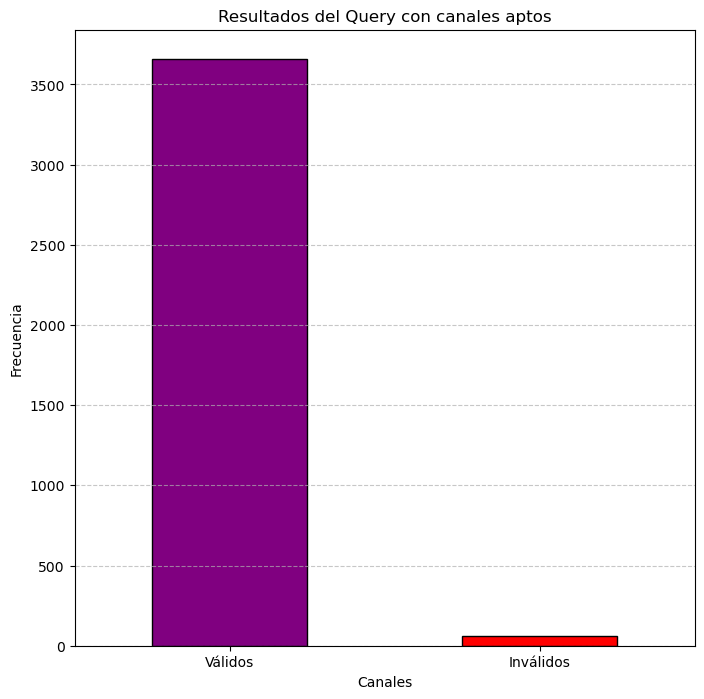

In [ ]:
plt.figure(figsize=(8,8))
df.technology.value_counts().plot(kind="bar", color=["purple", "red"], edgecolor='black')
plt.title("Tecnología apta")
plt.xlabel("Tecnología")
plt.ylabel("Frecuencia")
plt.xticks(rotation=0)
plt.xticks(ticks=[0,1], labels=["Válidos", "Inválidos"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout
plt.show()

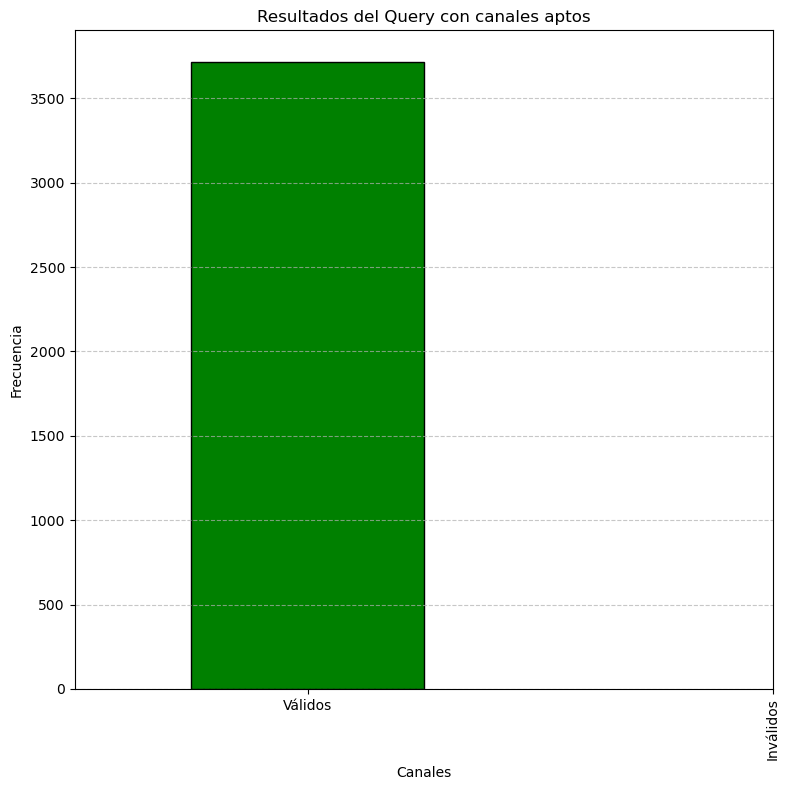

In [ ]:
plt.figure(figsize=(8,8))
df.valid_ch1_2.value_counts().plot(kind="bar", color=["green", "blue"], edgecolor='black')
plt.title("Resultados del Query con canales aptos")
plt.xlabel("Canales")
plt.ylabel("Frecuencia")
plt.xticks(rotation=0)
plt.xticks(ticks=[0,1], labels=["Válidos", "Inválidos"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [83]:
df[df.valid_ch1_2 == False]

Empty DataFrame
Columns: [title, geo_accession, status, submission_date, last_update_date, type, channel_count, source_name_ch1, organism_ch1, taxid_ch1, characteristics_ch1, treatment_protocol_ch1, growth_protocol_ch1, molecule_ch1, extract_protocol_ch1, label_ch1, label_protocol_ch1, source_name_ch2, organism_ch2, taxid_ch2, characteristics_ch2, treatment_protocol_ch2, growth_protocol_ch2, molecule_ch2, extract_protocol_ch2, label_ch2, label_protocol_ch2, hyb_protocol, scan_protocol, data_processing, platform_id, contact_name, contact_email, contact_department, contact_institute, contact_address, contact_city, contact_state, contact_zip/postal_code, contact_country, supplementary_file, series_id, data_row_count, description, contact_phone, contact_laboratory, relation, instrument_model, library_selection, library_source, library_strategy, supplementary_file_1, supplementary_file_2, contact_fax, contact_web_link, biomaterial_provider_ch1, biomaterial_provider_ch2, technology, valid_ch1_2, has_suplementary_file(s), suplementary_files_number]
Index: []

[0 rows x 61 columns]

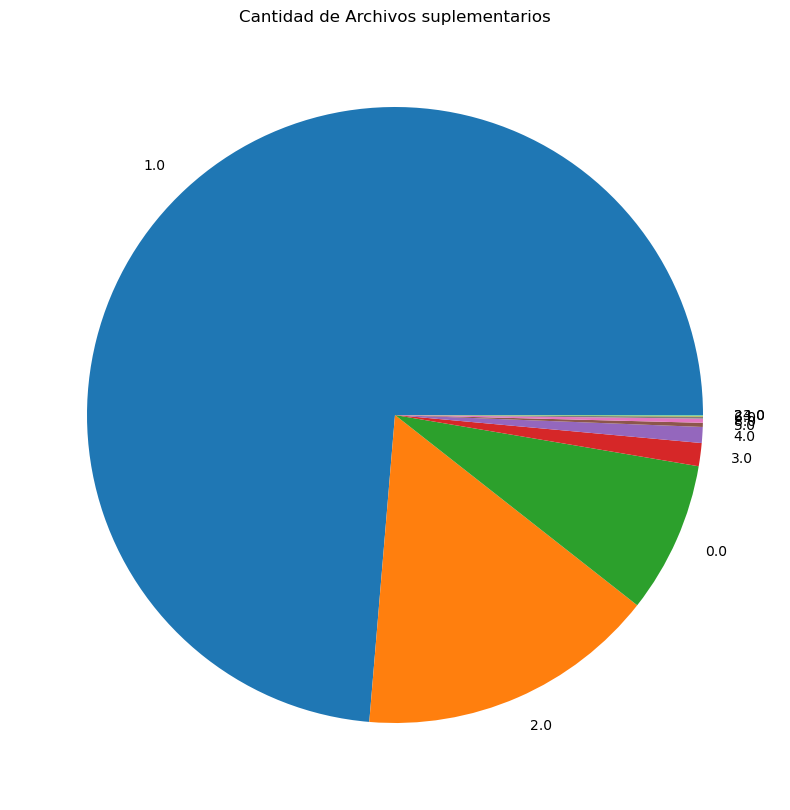

suplementary_files_number
1.0     2739
2.0      585
0.0      295
3.0       45
4.0       31
5.0        8
8.0        8
6.0        4
24.0       2
23.0       1
Name: count, dtype: int64


In [70]:
valores = df.suplementary_files_number.value_counts()

plt.figure(figsize=(10,10))
valores.plot.pie()
plt.xlabel('')
plt.ylabel('')
plt.title('Cantidad de Archivos suplementarios')
plt.show()

print(valores)

In [110]:
df[(df.technology) & (df.valid_ch1_2) & (df.has_suplementary_file)] # Filas donde todas sean verdaderas

title geo_accession  \
GSM6262951                            [ChrS-Ala245fs_vs_WT_1]  [GSM6262951]   
GSM6262952                            [ChrS-Ala245fs_vs_WT_2]  [GSM6262952]   
GSM6262953                            [ChrS-Ala245fs_vs_WT_3]  [GSM6262953]   
GSM8782701  [Response of the parental JU15 strain during t...  [GSM8782701]   
GSM8782702  [Response of the parental JU15 strain during t...  [GSM8782702]   
...                                                       ...           ...   
GSM18285                                [anaerobic_soxS_rep3]    [GSM18285]   
GSM18286                                [anaerobic_wild_rep1]    [GSM18286]   
GSM18287                                [anaerobic_wild_rep2]    [GSM18287]   
GSM18288                                [anaerobic_wild_rep3]    [GSM18288]   
GSM18289                                [anaerobic_wild_rep4]    [GSM18289]   

                             status submission_date last_update_date   type  \
GSM6262951  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM6262952  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM6262953  [Public on Jul 22 2022]   [Jun 23 2022]    [Jul 22 2022]  [RNA]   
GSM8782701  [Public on May 29 2025]   [Feb 07 2025]    [May 29 2025]  [RNA]   
GSM8782702  [Public on May 29 2025]   [Feb 07 2025]    [May 29 2025]  [RNA]   
...                             ...             ...              ...    ...   
GSM18285    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18286    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18287    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18288    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   
GSM18289    [Public on Mar 10 2004]   [Mar 04 2004]    [Aug 01 2011]  [RNA]   

           channel_count                                    source_name_ch1  \
GSM6262951           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM6262952           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM6262953           [2]                          [ChrS-Ala245fs_4uM_hemin]   
GSM8782701           [2]  [Control samples of the parental strain JU15 a...   
GSM8782702           [2]  [Control samples of the parental strain JU15 a...   
...                  ...                                                ...   
GSM18285             [1]  [anaerobic growth of soxS knock-out strain on ...   
GSM18286             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18287             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18288             [1]  [anaerobic growth of wild-type strain on M9 me...   
GSM18289             [1]  [anaerobic growth of wild-type strain on M9 me...   

                            organism_ch1 taxid_ch1  ... supplementary_file_1  \
GSM6262951  [Corynebacterium glutamicum]    [1718]  ...                  NaN   
GSM6262952  [Corynebacterium glutamicum]    [1718]  ...                  NaN   
GSM6262953  [Corynebacterium glutamicum]    [1718]  ...                  NaN   
GSM8782701            [Escherichia coli]     [562]  ...                  NaN   
GSM8782702            [Escherichia coli]     [562]  ...                  NaN   
...                                  ...       ...  ...                  ...   
GSM18285              [Escherichia coli]     [562]  ...                  NaN   
GSM18286              [Escherichia coli]     [562]  ...                  NaN   
GSM18287              [Escherichia coli]     [562]  ...                  NaN   
GSM18288              [Escherichia coli]     [562]  ...                  NaN   
GSM18289              [Escherichia coli]     [562]  ...                  NaN   

           supplementary_file_2 contact_fax contact_web_link  \
GSM6262951                  NaN         NaN              NaN   
GSM6262952                  NaN         NaN              NaN   
GSM6262953                  NaN         NaN             

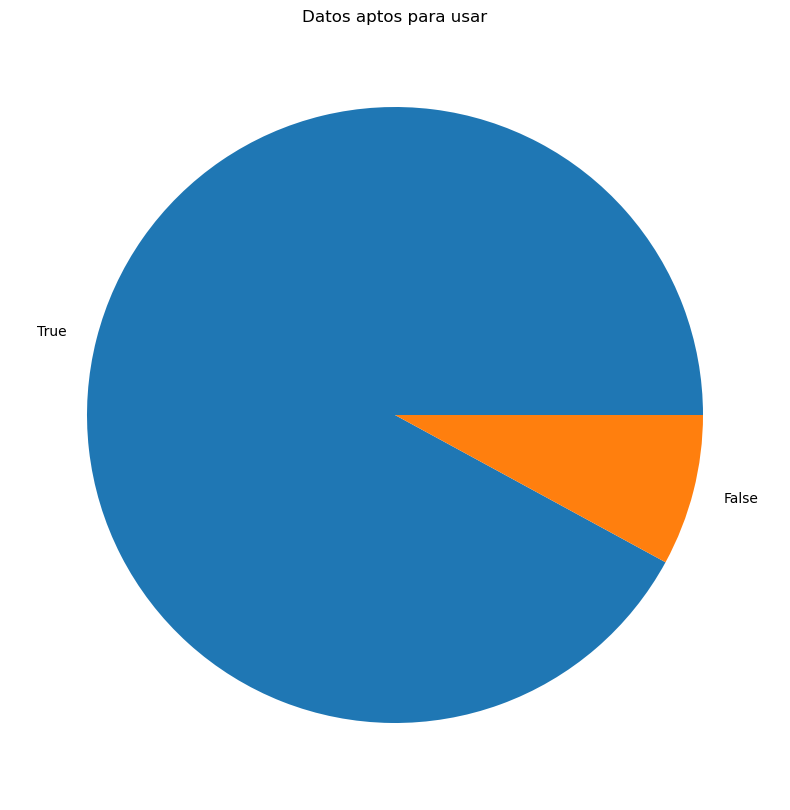

True     3423
False     295
Name: count, dtype: int64


In [113]:
conteo = (df.technology & df.valid_ch1_2 & df.has_suplementary_file).value_counts() 

plt.figure(figsize=(10,10))
conteo.plot.pie()
plt.xlabel('')
plt.ylabel('')
plt.title('Datos aptos para usar')
plt.show()

print(conteo)